In [1]:
#! /usr/bin/env python
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# from matplotlib.backends.backend_tkagg  import NavigationToolbar2TkAgg

from matplotlib.figure import Figure
try: # Python 3
    import tkinter as tk
    from tkinter import ttk
    from _tkinter import TclError
except ImportError:  # Python 2
    import Tkinter as tk
    from _tkinter import TclError
    import ttk



#### The planet class contains the physics, the orbital motion of the planet around the central body

In [2]:
'''
    The planet class contains the physics, the orbital motion of the planet around the central body
'''

class Planet():

    def __init__(self, a, T, e, m, sim, c):

        # Physical properties
        self.semiMajor = a
        self.orbitalPeriod = T
        self.eccentricity = e
        self.mass = m * M * 1e-6    # m is mass in solar mass units

        # Calculate radius of region where planet's gravitational  influence on spacecraft
        # dominates all other influences
        self.sphereOfInfluence = self.semiMajor * np.power(self.mass / M, 2/5)

        # Included in simulation
        self.simulate = sim
        self.colour = c
        self.linestyle = '-'
        self.marker = 'o'

        # Simulation quantities
        self.eccentricAnomaly = None    # later angle in radians
        self.position = None            # later given as (x, y) coordinate
        self.velocity = None            # later given as (vx, vy) components


    def distanceToSun(self):
        x, y = self.position
        return np.sqrt(x**2 + y**2)

    def getVelocity(self):
        x, y = self.velocity
        return np.sqrt(x**2 + y**2)


    def calculateInitialPosition(self):
        # Use distance and anomaly to calculate initial positions x0, y0
        distance = self.semiMajor * (1. - self.eccentricity)
        return (distance*np.sin(self.eccentricAnomaly), -distance*np.cos(self.eccentricAnomaly))


    def calculateInitialVelocity(self, delta):
        # Calculating the x- and y-components requires the specific timestep of the simulation
        # Taylor approximation of velocities at step n=1/2
        velocity = np.sqrt(G * M * (2./self.distanceToSun() - 1./self.semiMajor))
        return (velocity * np.cos(self.eccentricAnomaly) - G * M * self.position[0]/self.distanceToSun()**3 * delta/2,
                velocity * np.sin(self.eccentricAnomaly) - G * M * self.position[1]/self.distanceToSun()**3 * delta/2)

    def updatePosition(self, delta):
        # Return tuple with updated position
        return tuple(i + delta * vi for i, vi in zip(self.position, self.velocity)) # for i in x, y

    def updateVelocity(self, delta):
        # Return tuple with updated velocity, using leap-frog integration scheme
        return tuple(i - (delta * G * M * ri) / self.distanceToSun()**3 for i, ri in zip(self.velocity, self.position))



#### This class handles the simulation parameters

In [3]:
'''
    This class handles the simulation parameters
'''
class SolarSystemSimulation():


    Planets = {}

    def __init__(self):

        self.delta = gui.stepsize.get() * 2*np.pi / (np.sqrt(G*M) * 365.256)   # integration timestep in Earth days
        self.steps = round(365.256 * gui.duration.get() / gui.stepsize.get())  # integration time in Earth years

        self.originPlanet = ''          # HTO Planets
        self.destinationPlanet = ''

        # ------
        # Initialize Planets
        # Units of AU and Year
        Mercury = Planet(a=0.387, e=0.205, T=0.241, m=0.166014,     sim=gui.mercury.get(), c ='Gold')
        Venus   = Planet(a=0.723, e=0.007, T=0.615, m=2.08106272,   sim=gui.venus.get(),   c ='Coral')
        Earth   = Planet(a=1.,    e=0.017, T=1.,    m=3.003486962,  sim=gui.earth.get(),   c ='DarkBlue')
        Mars    = Planet(a=1.524, e=0.094, T=1.88,  m=0.3232371722, sim=gui.mars.get(),    c ='Crimson')
        Jupiter = Planet(a=5.203, e=0.049, T=11.9,  m=954.7919,     sim=gui.jupiter.get(), c ='orange')
        Saturn  = Planet(a=9.58,  e=0.057, T=29.5,  m=285.885670,   sim=gui.saturn.get(),  c ='Khaki')
        Uranus  = Planet(a=19.20, e=0.046, T=84,    m=43.66244,     sim=gui.uranus.get(),  c ='Turquoise')
        Neptune = Planet(a=30.06, e=0.011, T=164.8, m=51.51384,     sim=gui.neptune.get(), c ='RoyalBlue')

        # For easier interaction between tkinter and class code, place the planet instances in a dict
        SolarSystemSimulation.Planets = {
           'Mercury':  Mercury,
           'Venus':    Venus,
           'Earth':    Earth,
           'Mars':     Mars,
           'Jupiter':  Jupiter,
           'Saturn':   Saturn,
           'Uranus':   Uranus,
           'Neptune':  Neptune
        }

        # ------
        # Hohmann Transfer Orbit Parameters
        if gui.plotHohmann.get():
            # User has to have selected origin and destination of Hohmann Transfer. If not,
            # this function just returns a message and does nothing
            try:
                self.originPlanet, self.destinationPlanet = gui.origin.get(gui.origin.curselection()), gui.destination.get(gui.destination.curselection())
            except TclError:
                print('\n ! You have to select origin and destination planet of the Hohmann Transfer Orbit ! \n')
                return None

        # ------
        # If planet is in simulation, determine its initial position and velocity
        for key, planet in SolarSystemSimulation.Planets.copy().items():
            if planet.simulate or key in [self.originPlanet, self.destinationPlanet]:
                # Randomly place the planets on their respective orbits
                planet.eccentricAnomaly = np.random.uniform(0, 2*np.pi)

                planet.position = planet.calculateInitialPosition()
                planet.velocity = planet.calculateInitialVelocity(self.delta)

            else: # if planets are not part of the simulation, remove them
                SolarSystemSimulation.Planets.pop(key)


    def timeStep(self):
        # Update planet position and velocity after one timestep
        for planet in SolarSystemSimulation.Planets.values():
            planet.position = planet.updatePosition(self.delta)
            planet.velocity = planet.updateVelocity(self.delta)

#### Class for defining spacecrafts/planets

In [4]:
'''
    Class for defining spacecrafts/planets
'''
class Spacecraft(Planet):

    def __init__(self, origin, destination, delta):

        self.origin = origin            # Instance of Planet Class
        self.destination = destination  # Instance of Planet Class

        self.position = origin.position
        self.eccentricAnomaly = origin.eccentricAnomaly
        self.velocity = self.calculateInitialVelocity(delta)

        self.colour = 'Maroon'
        self.linestyle = '--'
        self.marker = 'd'
        self.simulate = False           # This is to exclude HTO from plot limits check

        self.orbitInserted = False

    def calculateInitialVelocity(self, delta):
        # Initial velocity is defined by the distance the spacecraft has to travel
        dO = self.origin.semiMajor * (1 - self.origin.eccentricity)  # Leave at perihelion
        dD = self.destination.semiMajor                                  # Arrive at aphelion

        # The velocity of the spacecraft is defined by the HTO parameters
        velocity = np.sqrt(G*M/dO) + np.sqrt(G*M/dO) * (np.sqrt(2*dD / (dD + dO)) - 1)
        return (velocity*np.cos(self.eccentricAnomaly) - G*M*self.origin.position[0]/self.origin.distanceToSun()**3 * delta/2,
                velocity*np.sin(self.eccentricAnomaly) - G*M*self.origin.position[1]/self.origin.distanceToSun()**3 * delta/2)

    def performOrbitInsertion(self, Sim):
        if not Sim.Planets['HTO'].orbitInserted:
            # Adjusts the spacecraft's velocity if it has not been done yet
            semiMajorOrigin = Sim.Planets[Sim.originPlanet].semiMajor
            semiMajorDestination = Sim.Planets[Sim.destinationPlanet].semiMajor

            requiredAcceleration = np.sqrt(G*M/semiMajorDestination) * (1 - np.sqrt(2 * semiMajorOrigin / (semiMajorOrigin + semiMajorDestination))) # x-component
            # Acceleration is split up into x- and y-component
            Sim.Planets['HTO'].velocity = (Sim.Planets['HTO'].velocity[0] + requiredAcceleration*(Sim.Planets['HTO'].velocity[0]/Sim.Planets['HTO'].getVelocity()),
                                           Sim.Planets['HTO'].velocity[1] + requiredAcceleration*(Sim.Planets['HTO'].velocity[1]/Sim.Planets['HTO'].getVelocity()))
            Sim.Planets['HTO'].orbitInserted = True


#### Class for the GUI for the code

In [5]:
'''
    Class for the GUI for the code
'''
class App:
    # ------
    # Set up control window

    def __init__(self, master):
        self.master = master

        # ------
        # Top left: Quit button
        self.quit = ttk.Button(master, text='Quit', command=quit)
        self.quit.grid(column=0, row=0, sticky='EW')

        # ------
        # Upper Panel: Select Planets to Plot
        self.planet_frame = ttk.LabelFrame(master, text='Choose Planets to Plot')
        self.planet_frame.grid(row=1, columnspan=5, sticky='EW')

        # Planets
        self.mercury = tk.BooleanVar()
        self.venus = tk.BooleanVar()
        self.earth = tk.BooleanVar()
        self.mars = tk.BooleanVar()
        self.jupiter = tk.BooleanVar()
        self.saturn = tk.BooleanVar()
        self.uranus = tk.BooleanVar()
        self.neptune = tk.BooleanVar()

        self.plot_mercury = ttk.Checkbutton(self.planet_frame, text='Mercury', variable=self.mercury)
        self.plot_mercury.grid(row=1, column=0, sticky='EW', padx=5, pady=5)
        self.plot_venus = ttk.Checkbutton(self.planet_frame, text='Venus', variable=self.venus)
        self.plot_venus.grid(row=2, column=0, sticky='EW', padx=5, pady=5)
        self.plot_earth = ttk.Checkbutton(self.planet_frame, text='Earth', variable=self.earth)
        self.plot_earth.grid(row=3, column=0, sticky='EW', padx=5, pady=5)
        self.plot_mars = ttk.Checkbutton(self.planet_frame, text='Mars', variable=self.mars)
        self.plot_mars.grid(row=4, column=0, sticky='EW', padx=5, pady=5)
        self.plot_jupiter = ttk.Checkbutton(self.planet_frame, text='Jupiter', variable=self.jupiter)
        self.plot_jupiter.grid(row=1, column=1, sticky='EW', padx=5, pady=5)
        self.plot_saturn = ttk.Checkbutton(self.planet_frame, text='Saturn', variable=self.saturn)
        self.plot_saturn.grid(row=2, column=1, sticky='EW', padx=5, pady=5)
        self.plot_uranus = ttk.Checkbutton(self.planet_frame, text='Uranus', variable=self.uranus)
        self.plot_uranus.grid(row=3, column=1, sticky='EW', padx=5, pady=5)
        self.plot_neptune = ttk.Checkbutton(self.planet_frame, text='Neptune', variable=self.neptune)
        self.plot_neptune.grid(row=4, column=1, sticky='EW', padx=5, pady=5)

        # ------
        # Lower Panel: Hohmann Transfer Orbit selection
        self.transfer_frame = ttk.LabelFrame(master, text='Choose Origin and Destination')
        self.transfer_frame.grid(row=5, columnspan=5, sticky='EW')

        self.origin = tk.Listbox(self.transfer_frame, exportselection=0)
        self.origin.grid(row=6, column=0, sticky='EW')
        for planet in planets:
            self.origin.insert(0, planet)

        self.destination = tk.Listbox(self.transfer_frame, exportselection=0)
        self.destination.grid(row=6, column=2, sticky='EW')
        for planet in planets:
            self.destination.insert(0, planet)

        self.plotHohmann = tk.BooleanVar()
        self.orbitInsertion = tk.BooleanVar()

        self.plotHohmann_check = ttk.Checkbutton(self.transfer_frame, text='Plot Hohmann Transfer Orbit', variable=self.plotHohmann)
        self.plotHohmann_check.grid(row=7, column=0, sticky='EW', padx=5, pady=5)

        self.orbitInsertion_check = ttk.Checkbutton(self.transfer_frame, text='Orbit Insertion', variable=self.orbitInsertion)
        self.orbitInsertion_check.grid(row=7, column=2, sticky='EW', padx=5, pady=5)

        self.suggestionButton = ttk.Button(master, text='Suggest Simulation Parameters', command=self.suggestSimParameters)
        self.suggestionButton.grid(column=1, row=9, sticky='EW')


        # ------
        # Other settings

        self.stepsize = tk.DoubleVar()      # Integration timestep in Earth days
        tk.Entry(self.transfer_frame, textvariable=self.stepsize).grid(row=10, column=0, sticky='EW')
        tk.Label(self.transfer_frame, text='Timestep in Earth days').grid(row=10, column=2, sticky='E')

        self.duration = tk.DoubleVar()
        tk.Entry(self.transfer_frame, textvariable=self.duration).grid(row=11, column=0, sticky='EW')
        tk.Label(self.transfer_frame, text='Integration Time in Earth Years').grid(row=11, column=2, sticky='E')

        self.plot_button = ttk.Button(master, text='Plot', command=self.plot)
        self.plot_button.grid(column=1, row=12, sticky='EW')

        self.animate_button = ttk.Button(master, text='Animate', command=self.simulation_animation)
        self.animate_button.grid(column=2, row=12, sticky='EW')

        self.movie_button = ttk.Button(master, text='Save as mp4', command=self.movie)
        self.movie_button.grid(column=2, row=13, sticky='EW')

        # ------
        # Set-up initial scenario for easy use
        self.plotHohmann.set(True)
        self.orbitInsertion.set(True)
        self.mercury.set(True)
        self.venus.set(True)
        self.earth.set(True)
        self.mars.set(True)
        self.jupiter.set(True)
        self.origin.select_set(2)
        self.destination.select_set(3)
        self.duration.set(0.72)
        self.stepsize.set(1.0)


    def plot(self):
        # ------
        # Start simulation
        Sim = SolarSystemSimulation()

        # ------
        # Create new window to plot the simulation
        sim_window = tk.Toplevel()
        sim_window.title('SolarSystemSimulation')
        sim_window.focus_force()    # Auto-focus on window

        # Add interrupt button
        killswitch = ttk.Button(sim_window, text="Close Simulation", command=sim_window.destroy)
        killswitch.pack()

        fig, ax, elapsedTime = self.setupPlot(Sim)

        # Check if HTO is plotted
        if gui.plotHohmann.get():
            Sim, travelTime, transferDistanceAU = self.hohmannTransfer(Sim)

        # ------
        # Add Information to Plot
        info = self.addInformation(ax)
        info['elapsedTime'].set_text('Elapsed Time: {:.2f} Earth years'.format(gui.duration.get()))

        if gui.plotHohmann.get():
            info['originDestination'].set_text('%s \u2192 %s' % (Sim.originPlanet, Sim.destinationPlanet))
            info['transferTime'].set_text('Transfer Time: %.2f Earth Years' % travelTime)
            info['transferDistance'].set_text('Transfer Distance: %.1f AU' % transferDistanceAU)

        # ------
        # Create plotting canvas
        canvas = FigureCanvasTkAgg(fig, sim_window)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)

        # Add matplotlib toolbar to the plot
        toolbar = NavigationToolbar2TkAgg(canvas, sim_window)
        toolbar.update()
        canvas._tkcanvas.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # ------
        # Simulate and plot

        # For each planet in simulation, calculate trajectories
        planetTrajectories = {}
        for key, planet in Sim.Planets.items():
            planetTrajectories[key] = [planet.position]

        sphereOfInfluence = Sim.Planets[Sim.destinationPlanet].sphereOfInfluence  # in AU

        for i in range(Sim.steps):
            Sim.timeStep()
            for key, planet in Sim.Planets.items():
                planetTrajectories[key].append(planet.position)

                # If orbit insertion is performed, check if spacecraft has arrived at planet
                if gui.plotHohmann.get():
                    if gui.orbitInsertion.get():
                        distanceToDestination = np.sqrt((Sim.Planets['HTO'].position[0]-Sim.Planets[Sim.destinationPlanet].position[0])**2 +
                                                        (Sim.Planets['HTO'].position[1]-Sim.Planets[Sim.destinationPlanet].position[1])**2)

                        if distanceToDestination < sphereOfInfluence:
                            Sim.Planets['HTO'].performOrbitInsertion(Sim)

        # Plot final trajectories
        for key, planet in Sim.Planets.items():
            ax.plot(*zip(*planetTrajectories[key]), ls=planet.linestyle, c=planet.colour, lw=0.5)
            ax.plot(*planetTrajectories[key][-1], marker=planet.marker, c=planet.colour)

        # Add Sun
        sun, = ax.plot((0, 0), c='orange', marker='o', ls='')

        canvas.draw()


    def simulation_animation(self):
        # ------
        # Start simulation
        Sim = SolarSystemSimulation()

        # ------
        # Create new window to plot the simulation
        sim_window = tk.Toplevel()
        sim_window.title('SolarSystemSimulation')
        sim_window.focus_force()    # Auto-focus on window

        # Check if HTO is plotted
        if gui.plotHohmann.get():
            Sim, travelTime, transferDistanceAU = self.hohmannTransfer(Sim)

        fig, ax, elapsedTime = self.setupPlot(Sim)

        # ------
        # Create plotting canvas
        canvas = FigureCanvasTkAgg(fig, sim_window)
        canvas.show()
        #canvas.draw()
        canvas.get_tk_widget().pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)

        # Add interrupt button
        killswitch = ttk.Button(sim_window, text="Close Simulation", command=sim_window.destroy)
        killswitch.pack()

        info = self.addInformation(ax)

        # For each planet in simulation, add an empty line and store the instance in dict
        planetTrajectories = {}
        for key, planet in Sim.Planets.items():
            line, = ax.plot([], [], ls=planet.linestyle, c=planet.colour, lw=0.5)
            sphere, = ax.plot([], [], marker=planet.marker, c=planet.colour)
            planetTrajectories[key] = (line, sphere)

        # Add Sun
        sun, = ax.plot([], [], c='orange', marker='o', ls='')

        def init():
            # Initialize the animation
            elapsedTime.set_text('')

            # If HTO is plotted, include information
            if gui.plotHohmann.get():
                info['originDestination'].set_text('%s \u2192 %s' % (Sim.originPlanet, Sim.destinationPlanet))
                info['transferTime'].set_text('Transfer Time: %.2f Earth Years' % travelTime)
                info['transferDistance'].set_text('Transfer Distance: %.1f AU' % transferDistanceAU)
                info['destinationDistance'].set_text('Distance to Destination:')
                info['transferStatus'].set_text('Transfer Status: in progress..')

            trajectories = []
            for line, sphere in planetTrajectories.values():
                line.set_data([], [])
                trajectories.append(line)
                sphere.set_data([], [])
                trajectories.append(sphere)

            sun.set_data([], [])
            trajectories.append(sun)

            return trajectories

        def animate(i):
            # Animate the simulation

            # ------
            # Update the planet positions
            Sim.timeStep()

            # Update the planet trajectories
            trajectories = []  # lines in plot
            for key, planet in Sim.Planets.items():
                # Append new position to line of trajectory
                planetTrajectories[key][0].set_data(tuple(x + [xi] for x, xi in zip(planetTrajectories[key][0].get_data(), planet.position)))
                trajectories.append(planetTrajectories[key][0])

                # Move planet sphere to current trajectory
                planetTrajectories[key][1].set_data(planet.position)
                trajectories.append(planetTrajectories[key][1])

            sun.set_data([0], [0])
            trajectories.append(sun)

            elapsedTimeNumber = i * gui.stepsize.get() / 365.256
            info['elapsedTime'].set_text('Elapsed Time: {:.2f} Earth Years'.format(elapsedTimeNumber))
            trajectories.append(info['elapsedTime'])

            # HTO updates
            if gui.plotHohmann.get():

                xSpacecraft, ySpacecraft = Sim.Planets['HTO'].position

                distancesToSpacecraft = {}
                for key, planet in Sim.Planets.items():
                    if key != 'HTO':
                        distancesToSpacecraft[key] = np.sqrt((xSpacecraft-planet.position[0])**2 +
                                                             (ySpacecraft-planet.position[1])**2)

                # Give distance to target planet
                info['destinationDistance'].set_text('Distance to Destination: %.1fAU' % distancesToSpacecraft[Sim.destinationPlanet])
                trajectories.append(info['destinationDistance'])

                # See if spacecraft has arrived in sphere of influence of planet
                sphereOfInfluence = Sim.Planets[Sim.destinationPlanet].sphereOfInfluence  # in AU
                if distancesToSpacecraft[Sim.destinationPlanet] <= sphereOfInfluence:
                    # The HTO succeeded
                    info['transferStatus'].set_text('Transfer Status: \u2714 completed')
                    trajectories.append(info['transferStatus'])
                    # If orbit insertion is true and has not yet been performed, perform second acceleration
                    if gui.orbitInsertion.get():
                        Sim.Planets['HTO'].performOrbitInsertion(Sim)

            return trajectories

        ani = animation.FuncAnimation(fig, animate, frames=Sim.steps, interval=0, blit=True, init_func=init, repeat=False)
        canvas.draw()


    def movie(self):
        # ------
        # Start simulation
        Sim = SolarSystemSimulation()

        fig, ax, elapsedTime = self.setupPlot(Sim)

        # ------
        # Hohmann Transfer Orbit

        # Check if HTO is plotted
        if gui.plotHohmann.get():
            Sim, travelTime, transferDistanceAU = self.hohmannTransfer(Sim)

        # ------
        # Add Information to Plot
        info = self.addInformation(ax)

        # For each planet in simulation, add an empty line and store the instance in dict
        planetTrajectories = {}
        for key, planet in Sim.Planets.items():
            line, = ax.plot([], [], ls=planet.linestyle, c=planet.colour, lw=0.5)
            sphere, = ax.plot([], [], marker=planet.marker, c=planet.colour)
            planetTrajectories[key] = (line, sphere)

        # Add Sun
        sun, = ax.plot([], [], c='orange', marker='o', ls='')

        def init():
            # Initialize the animation
            trajectories = []
            for line, sphere in planetTrajectories.values():
                line.set_data([], [])
                trajectories.append(line)
                sphere.set_data([], [])
                trajectories.append(sphere)
                elapsedTime.set_text('')

            sun.set_data([], [])
            trajectories.append(sun)

            # If HTO is plotted, include information
            if gui.plotHohmann.get():
                info['originDestination'].set_text('%s \u2192 %s' % (Sim.originPlanet, Sim.destinationPlanet))
                info['transferTime'].set_text('Transfer Time: %.2f Earth Years' % travelTime)
                info['transferDistance'].set_text('Transfer Distance: %.1f AU' % transferDistanceAU)
                info['destinationDistance'].set_text('Distance to Destination:')
                info['transferStatus'].set_text('Transfer Status: in progress..')

            return trajectories

        def animate(i):
            # Animate the simulation

            # ------
            # Update the planet positions
            Sim.timeStep()

            # Update the planet trajectories
            trajectories = []  # lines in plot
            for key, planet in Sim.Planets.items():
                # Append new position to line of trajectory
                planetTrajectories[key][0].set_data(tuple(x + [xi] for x, xi in zip(planetTrajectories[key][0].get_data(), planet.position)))
                trajectories.append(planetTrajectories[key][0])

                # Move planet sphere to current trajectory
                planetTrajectories[key][1].set_data(planet.position)
                trajectories.append(planetTrajectories[key][1])

            sun.set_data([0], [0])
            trajectories.append(sun)

            elapsedTimeNumber = i * gui.stepsize.get() / 365.256
            info['elapsedTime'].set_text('Elapsed Time: {:.2f} Earth years'.format(elapsedTimeNumber))
            trajectories.append(info['elapsedTime'])

            # HTO updates
            if gui.plotHohmann.get():
                # Find planet closest to spacecraft
                xSpacecraft, ySpacecraft = Sim.Planets['HTO'].position

                distancesToSpacecraft = {}

                for key, planet in Sim.Planets.items():
                    if key != 'HTO':
                        distancesToSpacecraft[key] = np.sqrt((xSpacecraft-planet.position[0])**2 +
                                                             (ySpacecraft-planet.position[1])**2)
                #closestPlanetText = min(distancesToSpacecraft, key=distancesToSpacecraft.get)
                #closestPlanet.set_text('Closest Planet: %s' % closestPlanetText)

                # Give distance to target planet
                info['destinationDistance'].set_text('Distance to Destination: %.1fAU' % distancesToSpacecraft[Sim.destinationPlanet])

                #trajectories.append(closestPlanet)
                trajectories.append(info['destinationDistance'])

                # See if spacecraft has arrived in sphere of influence of planet
                sphereOfInfluence = Sim.Planets[Sim.destinationPlanet].sphereOfInfluence  # in AU

                if distancesToSpacecraft[Sim.destinationPlanet] <= sphereOfInfluence:
                    # The HTO succeeded
                    info['transferStatus'].set_text('Transfer Status: \u2714 completed')
                    trajectories.append(info['transferStatus'])
                    # If orbit insertion is true and has not yet been performed, perform second acceleration
                    if gui.orbitInsertion.get():
                        Sim.Planets['HTO'].performOrbitInsertion(Sim)

            return trajectories

        ani = animation.FuncAnimation(fig, animate, frames=Sim.steps, interval=0, blit=True, init_func=init)
        ani.save('SolarSystemSimulation.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        return 0


    def setupPlot(self, Sim):
        # ------
        # Plot set-up
        fig = plt.figure(figsize=(8, 8))
        # Determine plot limits by finding planet with largest semi-major axis included in simulation
        lim = 0.4
        for planet in Sim.Planets.values():
            if planet.simulate:
                if planet.semiMajor > lim:
                        lim = planet.semiMajor
        lim *= 1.2
        ax = fig.add_subplot(111, xlim=(-lim, lim), ylim=(-lim, lim), aspect='equal', autoscale_on=False)
        #ax.set(xlabel='x / AU', ylabel='y / AU')
        elapsedTime = ax.text(0.65, 0.95, '', transform=ax.transAxes)

        # Move axis to centre
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # Make axes more subtle
        ax.spines['left'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.tick_params(axis='x', colors='none')
        ax.tick_params(axis='y', colors='none')
        ax.xaxis.label.set_color('none')
        ax.yaxis.label.set_color('none')

        plt.tight_layout()
        return fig, ax, elapsedTime


    def addInformation(self, ax):
        info = {}
        # Upper part shows basic information
        info['originDestination'] = ax.text(0.45, 0.95, '', transform=ax.transAxes)
        info['transferTime'] = ax.text(0.01, 0.93, '', transform=ax.transAxes)
        info['transferDistance'] = ax.text(0.01, 0.91, '', transform=ax.transAxes)
        info['elapsedTime'] = ax.text(0.65, 0.93, '', transform=ax.transAxes)
        info['destinationDistance'] = ax.text(0.65, 0.91, '', transform=ax.transAxes)
        info['transferStatus'] = ax.text(0.65, 0.89, '', transform=ax.transAxes)
        return info


    def hohmannTransfer(self, Sim):
        # The initial position and velocities of the origin and destination planet have to be adjusted
        # and their eccentricities set to zero
        for i, planet in enumerate([Sim.Planets[Sim.originPlanet], Sim.Planets[Sim.destinationPlanet]]):
            planet.eccentricity = 0
            # Planets need angular offset in order for the spacecraft to arrive at the correct time
            if i == 0:
                # The destination planet has to have an angular offset with respect to the origin planet
                # in order for the spacecraft to arrive at the destination planet at the correct time
                # The offset depends on the travel time. Using Kepler's third law in units of 1 AU and 1 Earth year: T^2/a^3=const
                dO = planet.semiMajor * (1 - planet.eccentricity)  # Leave at perihelion
                dD = Sim.Planets[Sim.destinationPlanet].semiMajor            # Arrive at aphelion

                semiMajorHTO = (dO + dD) / 2
                travelTime = np.sqrt(semiMajorHTO**3) / 2    # Only half-way required
                # Calculate required angular offset
                offset = travelTime/Sim.Planets[Sim.destinationPlanet].orbitalPeriod * 360.
                planet.eccentricAnomaly = np.radians(offset + 180)

            elif i ==1:
                planet.eccentricAnomaly = 0
            planet.position = planet.calculateInitialPosition()
            planet.velocity = planet.calculateInitialVelocity(Sim.delta)

        # ------
        # The HTO is simulated using the spacecraft class.
        # Initial velocity and position determine the trajectory, therefore
        # we can use the same Sim.timeStep function to calculate the orbit
        HTO = Spacecraft(origin=Sim.Planets[Sim.originPlanet], destination=Sim.Planets[Sim.destinationPlanet], delta=Sim.delta)
        # Now all left to do is to regard spacecraft as fake planet
        # and append to list of simulated planets
        Sim.Planets['HTO'] = HTO
        return Sim, travelTime, semiMajorHTO


    def suggestSimParameters(self):
        # ------
        # Initialize simulation
        Sim = SolarSystemSimulation()

        # Suggest timestep based on planet with smallest orbit included in simulation
        smallestOrbit = min([planet.orbitalPeriod for planet in Sim.Planets.values()])
        gui.stepsize.set(round(smallestOrbit * 365.263 / 100, 2))

        if gui.plotHohmann.get():
            # Set duration of simulation to 110% of the HTO travelTime
            dO = Sim.Planets[Sim.originPlanet].semiMajor * (1 - Sim.Planets[Sim.originPlanet].eccentricity)  # Leave at perihelion
            dD = Sim.Planets[Sim.destinationPlanet].semiMajor # Arrive at aphelion

            semiMajorHTO = (dO + dD) / 2
            travelTime = np.sqrt(semiMajorHTO**3) / 2    # Only half-way required
            gui.duration.set(round(travelTime * 1.1, 2))

        else:
            # Set to one orbital period of planet with largest orbiatl period in simulation
            gui.duration.set(round(max([planet.orbitalPeriod for planet in Sim.Planets.values()]), 2))


#### Plots

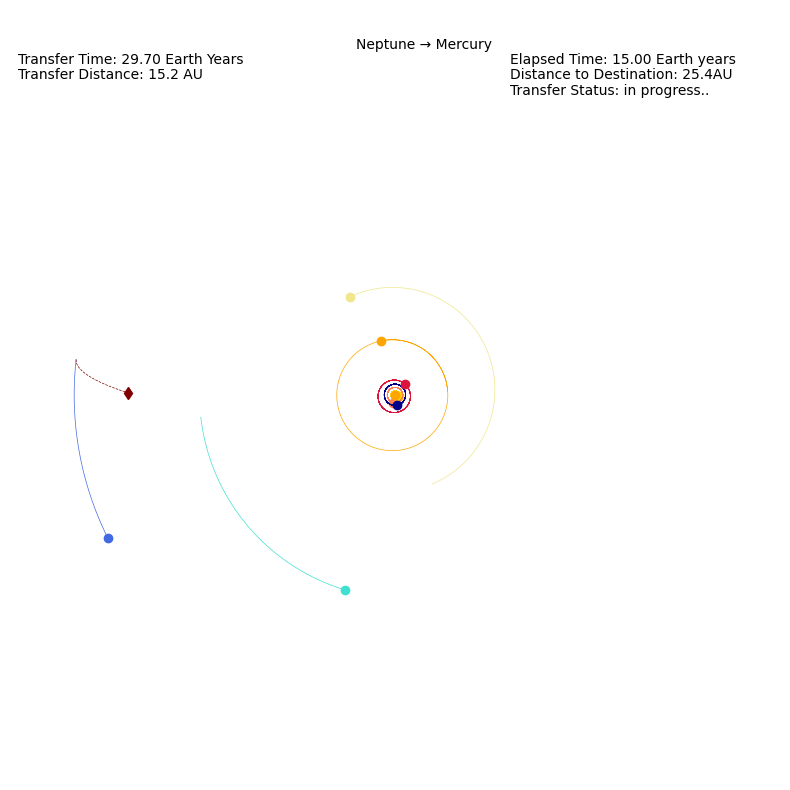

In [6]:
if __name__ == '__main__':

    # Some definitions
    planets = ['Neptune', 'Uranus', 'Saturn', 'Jupiter', 'Mars', 'Earth', 'Venus', 'Mercury']
    M = 1.998e30   # Solar Mass
    G = 6.67e-11   # Gravitational Constant

    # ------
    # Start GUI
    root = tk.Tk()
    root.wm_title('SolarSystemOrbiter')
    gui = App(root)
    root.mainloop()